# Chapter 13 Generate image with ControlNet


## Usage of ControlNet

In [1]:
# load the base model 
import torch
from diffusers import StableDiffusionPipeline

text2img_pipe = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype = torch.float16
).to("cuda:0")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

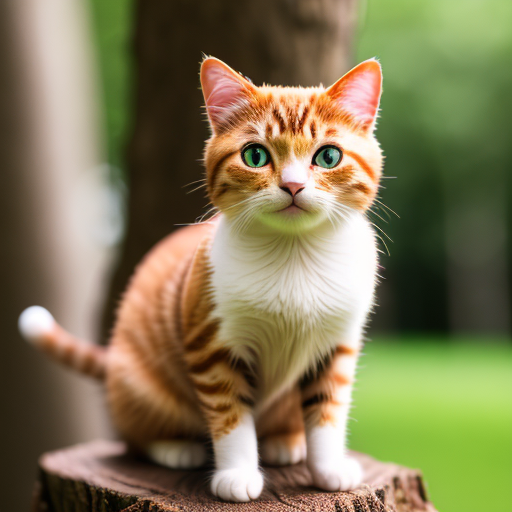

In [2]:
# Step 1. generate sample image
prompt = """
high resolution photo,best quality, masterpiece, 8k
A cute cat stand on the tree branch, depth of field, detailed body
"""

neg_prompt = """
paintings,ketches, worst quality, low quality, normal quality, lowres, 
monochrome, grayscale
"""

image = text2img_pipe(
    prompt = prompt
    , negative_prompt = neg_prompt
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

In [3]:
# Step 2. Generate the caney shape

# install opencv and controlnet_aux packages 
%pip install opencv-contrib-python
%pip install controlnet_aux

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\controlnet_aux\mediapipe_face\mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


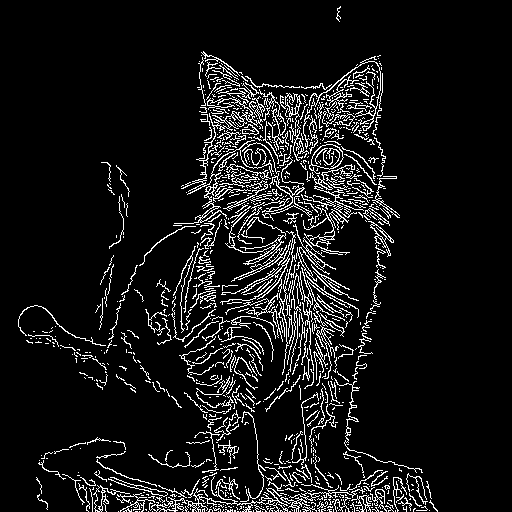

In [3]:
from controlnet_aux import CannyDetector
canny = CannyDetector()
canny_image = canny(image, 30, 100)
canny_image

In [4]:
# Step 3. Load up ControlNet model
from diffusers import ControlNetModel
canny_controlnet = ControlNetModel.from_pretrained(
    'takuma104/control_v11'
    , subfolder='control_v11p_sd15_canny'
    , torch_dtype=torch.float16
)

from diffusers import StableDiffusionControlNetPipeline
single_cn_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype           = torch.float16
    , controlnet            = canny_controlnet
).to("cuda")

control_v11p_sd15_canny/config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--takuma104--control_v11. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


diffusion_pytorch_model.safetensors:   0%|          | 0.00/723M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

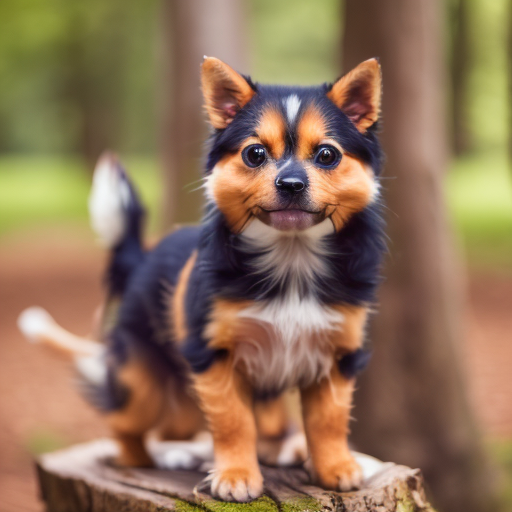

In [5]:
# Step 4. Generate image using ControlNet pipeline
prompt = """
high resolution photo,best quality, masterpiece, 8k
A cute dog stand on the tree branch, depth of field, detailed body
"""
neg_prompt = """
paintings,ketches, worst quality, low quality, normal quality, lowres, 
monochrome, grayscale
"""
image_from_canny = single_cn_pipe(
    prompt = prompt
    , negative_prompt = neg_prompt
    , image = canny_image
    , generator = torch.Generator("cuda").manual_seed(2)
    , num_inference_steps = 30
    , guidance_scale = 6.0
).images[0]
image_from_canny

## Use multiple ControlNets

scannet.pt:   0%|          | 0.00/291M [00:00<?, ?B/s]

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--lllyasviel--Annotators. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading base model ()...Done.
Removing last two layers (global_pool & classifier).


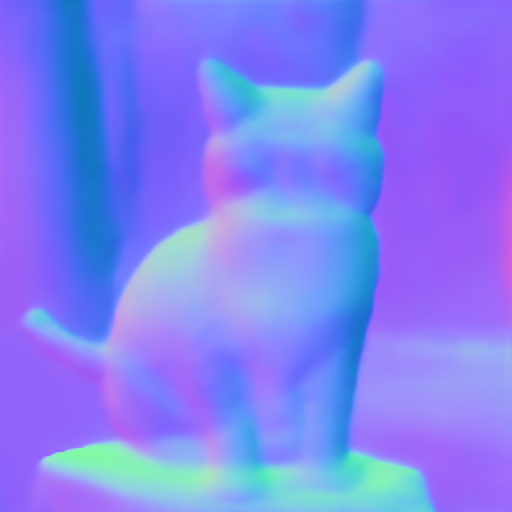

In [6]:
# create an canny image
from controlnet_aux import NormalBaeDetector
normal_bae  = NormalBaeDetector.from_pretrained("lllyasviel/Annotators")
bae_image   = normal_bae(image)
bae_image

In [7]:
# create a Normal BAE ControlNet
from diffusers import ControlNetModel
canny_controlnet = ControlNetModel.from_pretrained(
    'takuma104/control_v11'
    , subfolder='control_v11p_sd15_canny'
    , torch_dtype=torch.float16
)
bae_controlnet = ControlNetModel.from_pretrained(
    'takuma104/control_v11'
    , subfolder='control_v11p_sd15_normalbae'
    , torch_dtype=torch.float16
)
controlnets = [canny_controlnet, bae_controlnet]

control_v11p_sd15_normalbae/config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/723M [00:00<?, ?B/s]

In [8]:
# a pipeline with two controlnet models
from diffusers import StableDiffusionControlNetPipeline
two_cn_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype           = torch.float16
    , controlnet            = controlnets
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

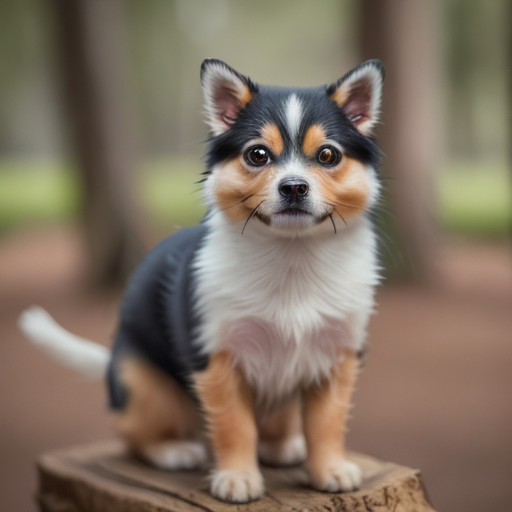

In [9]:
prompt = """
high resolution photo,best quality, masterpiece, 8k
A cute dog on the tree branch, depth of field, detailed body,
"""

neg_prompt = """
paintings,ketches, worst quality, low quality, normal quality, lowres, 
monochrome, grayscale
"""
image_from_2cn = two_cn_pipe(
    prompt = prompt
    , image                 = [canny_image,bae_image]
    , controlnet_conditioning_scale = [0.5,0.5]
    , generator             = torch.Generator("cuda").manual_seed(2)
    , num_inference_steps   = 30
    , guidance_scale        = 5.5
).images[0]
image_from_2cn

## Further Usage

### Stable Diffusion XL ControlNets

In [10]:
# initialize a Stable Diffusion XL pipeline
import torch
from diffusers import StableDiffusionXLPipeline
sdxl_pipe = StableDiffusionXLPipeline.from_pretrained(
    "RunDiffusion/RunDiffusion-XL-Beta"
    , torch_dtype           = torch.float16
    , load_safety_checker   = False
)
sdxl_pipe.watermark = None

Keyword arguments {'load_safety_checker': False} are not expected by StableDiffusionXLPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to

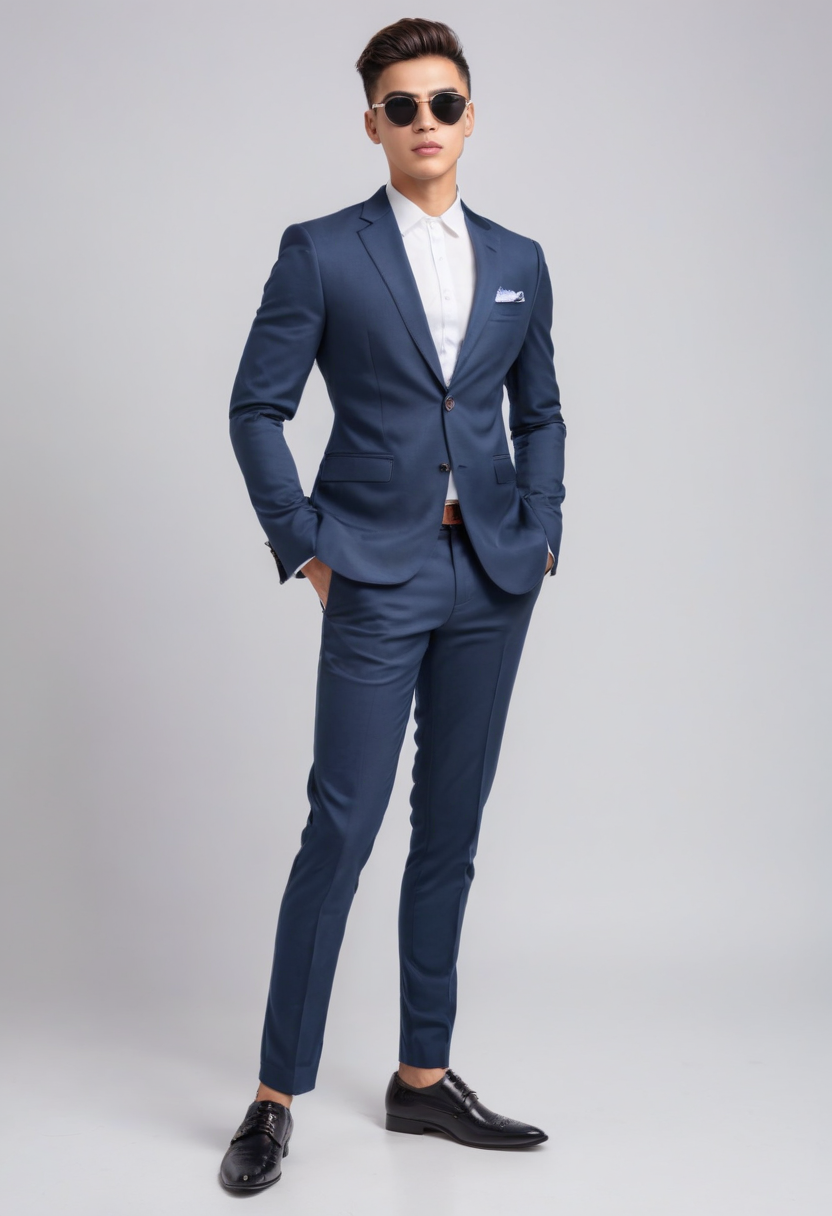

In [11]:
# use Stable Diffusion XL to generate an image
from diffusers import EulerDiscreteScheduler
prompt = """
full body photo of young man, arms spread
white blank background, 
glamour photography, 
wear sunglass,
upper body wears shirt, 
wears suit pants,
wears leather shoes
"""
neg_prompt = """
worst quality,low quality, paint, cg, spots, bad hands, 
three hands, noise, blur, bad anatomy, low resolution, 
blur face, bad face
"""
sdxl_pipe.to("cuda")

sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(sdxl_pipe.scheduler.config)
generator = torch.Generator("cuda").manual_seed(2)
image = sdxl_pipe(
    prompt              = prompt 
    , negative_prompt   = neg_prompt
    , width             = 832
    , height            = 1216
    , generator         = generator 
).images[0]
sdxl_pipe.to("cpu")
torch.cuda.empty_cache()
image

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

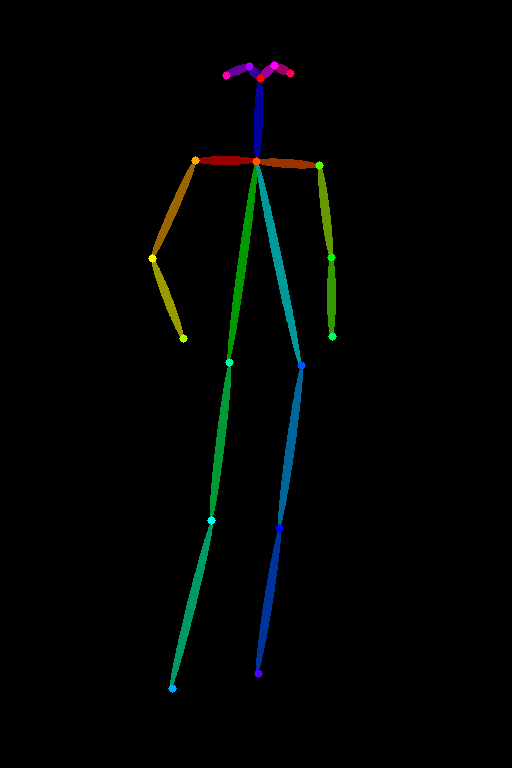

In [12]:
# extract the pose image
from controlnet_aux import OpenposeDetector
open_pose = OpenposeDetector.from_pretrained("lllyasviel/Annotators")
pose = open_pose(image)
pose

In [13]:
# start a ControlNet pipeline
from diffusers import StableDiffusionXLControlNetPipeline
from diffusers import ControlNetModel
sdxl_pose_controlnet = ControlNetModel.from_pretrained(
    "thibaud/controlnet-openpose-sdxl-1.0"
    , torch_dtype=torch.float16
)

sdxl_cn_pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "RunDiffusion/RunDiffusion-XL-Beta"
    , torch_dtype           = torch.float16
    , load_safety_checker   = False
    , add_watermarker       = False
    , controlnet            = sdxl_pose_controlnet
)
sdxl_cn_pipe.watermark = None

config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Keyword arguments {'load_safety_checker': False} are not expected by StableDiffusionXLControlNetPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 992.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.93 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/home/andrewzhu/storage_1t_1/az_git_folder/Using-Stable-Diffusion-with-Python/sd_book_prd_p310_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of 

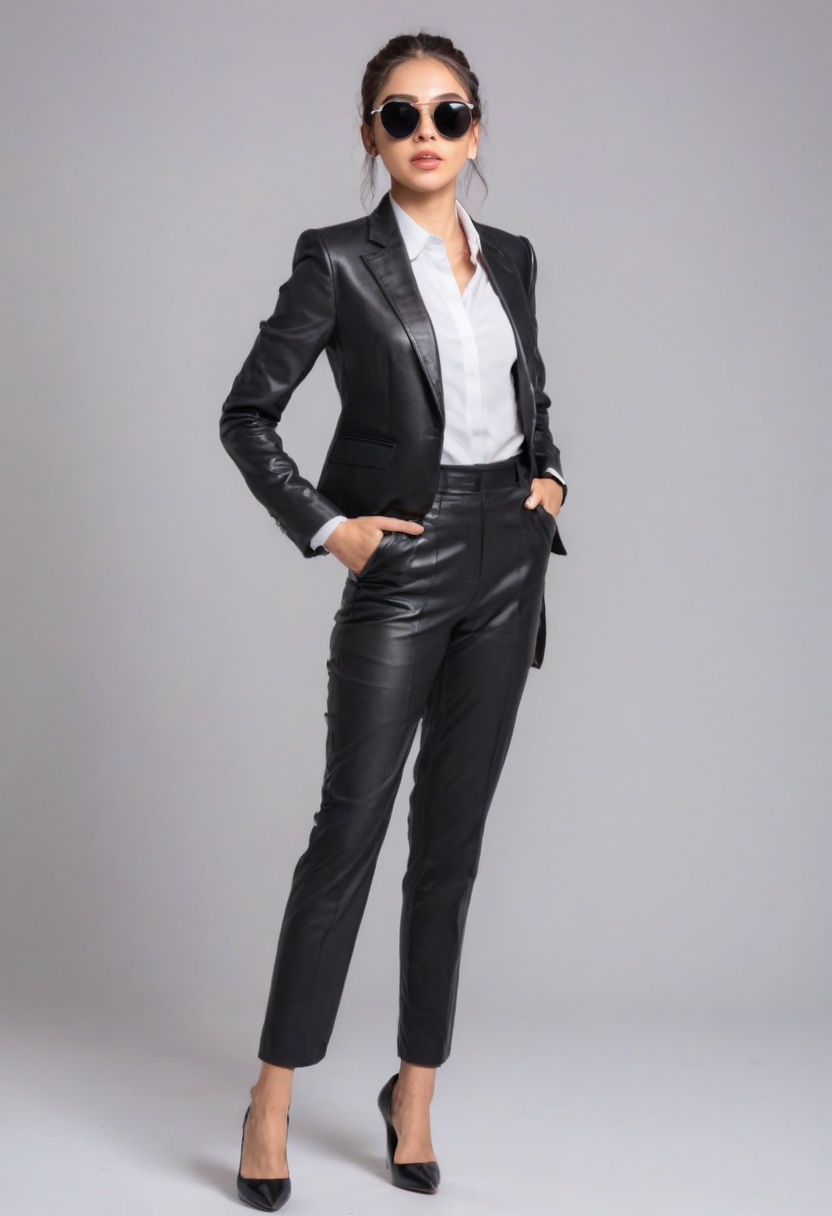

In [14]:
# Generate a new image use the ControlNet model
from diffusers import EulerDiscreteScheduler
prompt = """
full body photo of young woman, arms spread
white blank background, 
glamour photography, 
wear sunglass,
upper body wears shirt, 
wears suit pants,
wears leather shoes
"""
neg_prompt = """
worst quality,low quality, paint, cg, spots, bad hands, 
three hands, noise, blur, bad anatomy, low resolution, 
blur face, bad face
"""
sdxl_cn_pipe.to("cuda")
sdxl_cn_pipe.scheduler = EulerDiscreteScheduler.from_config(sdxl_cn_pipe.scheduler.config)
generator = torch.Generator("cuda").manual_seed(2)

image = sdxl_cn_pipe(
    prompt                          = prompt 
    , negative_prompt               = neg_prompt
    , width                         = 832
    , height                        = 1216
    , image                         = pose
    , generator                     = generator 
    , controlnet_conditioning_scale = 0.5
    , num_inference_steps           = 30
    , guidance_scale                = 6.0
).images[0]
sdxl_cn_pipe.to("cpu")
torch.cuda.empty_cache()
image